In [1]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from closest_grid_cell import select_nearest_grid_cell


Precipitation 

In [39]:
data_hr_precip= xr.open_dataset(f'{config.TARGET_DIR}/RhiresD_1971_2023.nc') #Need to select 1981-2010 only
data_hr_precip= data_hr_precip.sel(time=slice('1981-01-01', '2010-12-31'))

In [40]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [41]:
data_hr_precip_locarno = select_nearest_grid_cell(data_hr_precip, target_lat, target_lon, 'RhiresD')
    
precip_series_hr = data_hr_precip_locarno['data']
lat_idx = data_hr_precip_locarno['lat_idx']
lon_idx = data_hr_precip_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14


In [42]:
#Pyextremes needs a pandas data series 
precip_series_hr_pd= precip_series_hr.to_pandas()

In [43]:
#Block maxima plotting
bm_hr_pr= get_extremes(precip_series_hr_pd, method='BM', block_size='365D')

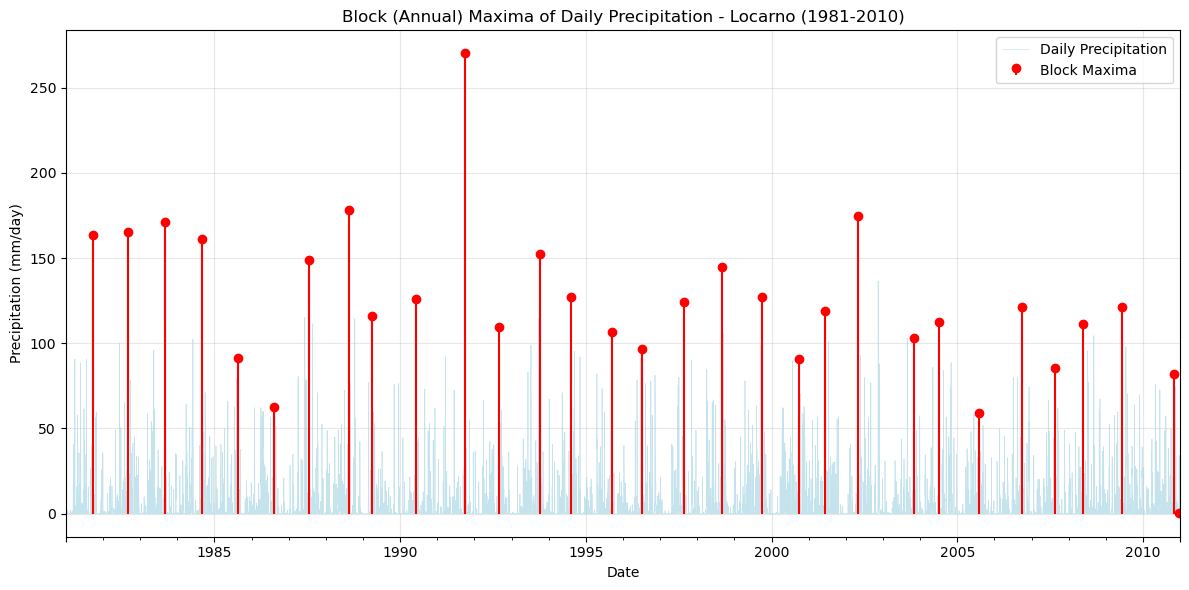

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

precip_series_hr_pd.plot(ax=ax, color='lightblue', alpha=0.7, linewidth=0.5, label='Daily Precipitation')

ax.stem(bm_hr_pr.index, bm_hr_pr.values, linefmt='red', markerfmt='ro', basefmt='none', label='Block Maxima')

ax.set_title('Block (Annual) Maxima of Daily Precipitation - Locarno (1981-2010)')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Temperature

In [49]:
data_hr_temp= xr.open_dataset(f'{config.TARGET_DIR}/TabsD_1971_2023.nc')
data_hr_temp= data_hr_temp.sel(time=slice('1981-01-01', '2010-12-31'))

In [50]:
data_hr_temp_locarno = select_nearest_grid_cell(data_hr_temp, target_lat, target_lon, 'TabsD')

temp_series_hr = data_hr_temp_locarno['data']
lat_idx = data_hr_temp_locarno['lat_idx']
lon_idx = data_hr_temp_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TabsD' extracted
Time series shape: (10957,)
Data range: -7.54 to 29.23


In [51]:
temp_series_hr_pd= temp_series_hr.to_pandas()

In [52]:
bm_hr_temp= get_extremes(temp_series_hr_pd, method='BM', block_size='365D')

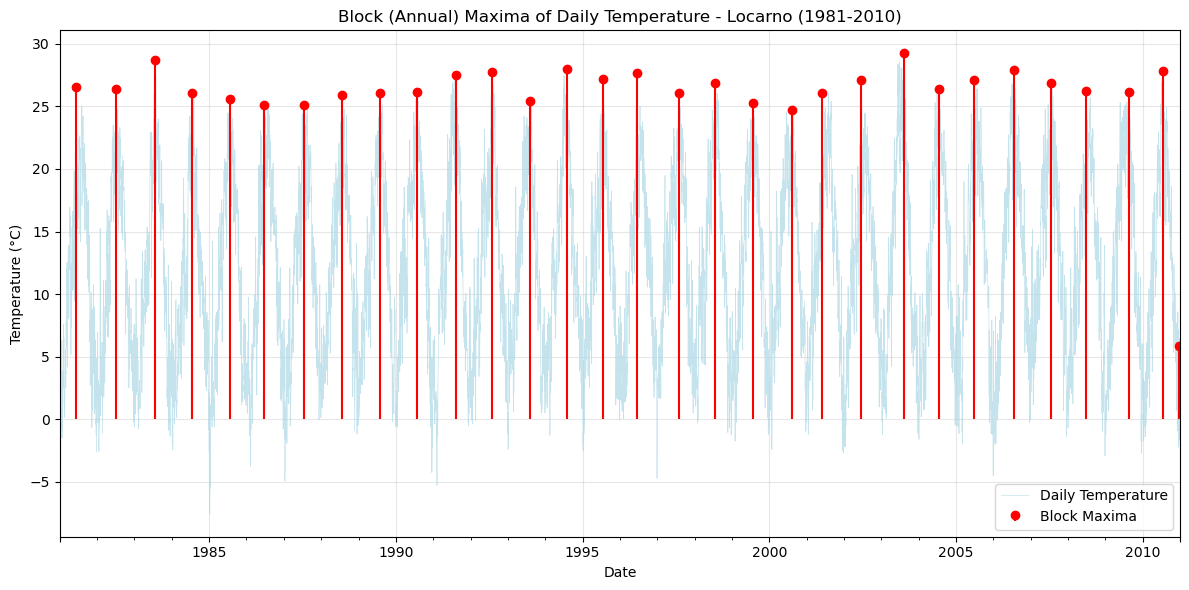

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))

temp_series_hr_pd.plot(ax=ax, color='lightblue', alpha=0.7, linewidth=0.5, label='Daily Temperature')

ax.stem(bm_hr_temp.index, bm_hr_temp.values, linefmt='red', markerfmt='ro', basefmt='none', label='Block Maxima')

ax.set_title('Block (Annual) Maxima of Daily Temperature - Locarno (1981-2010)')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()